In [1]:
from tensorflow.keras.applications import VGG19
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (18,18)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import functools
import time

In [2]:
# 如果模型下载失败，请按照报错信息链接手动下载模型，并保存到C:\Users\用户名\.keras\models
vgg = VGG19(input_shape=(224,224,3),weights="imagenet",include_top=False)

In [107]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
def load_img(img_path):
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [9]:
style_img_path = r"./3628e6bfcc271a0fcf84f268d1b68ea15ee74823.png"
content_video = r".\TheWindRises.mp4"

In [6]:
import cv2

In [15]:
cap = cv2.VideoCapture(content_video)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

if (cap.isOpened() == False): 
    print("Unable to read camera feed")

In [16]:
count = 0
while(True):
    count += 1
    ret, frame = cap.read()
#     frame = cv2.resize(frame,(224,224))
#     print(frame.shape)
    cv2.imwrite("test.jpg", frame)
    if count == 100 or not ret:
        break

In [17]:
cap.release()
cv2.destroyAllWindows()

In [6]:
test_content_img = r".\test.jpg"

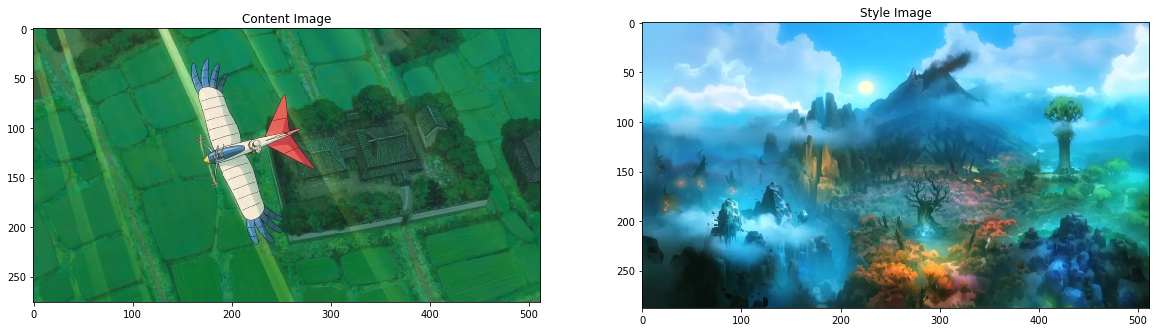

In [10]:
content_img = load_img(test_content_img)
style_img = load_img(style_img_path)
plt.subplots(figsize=(20,7))
plt.subplot(1,2,1)
imshow(content_img, "Content Image")
plt.subplot(1,2,2)
imshow(style_img, "Style Image")

In [11]:
content_layers = ["block5_conv2"] # 内容层
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1",]

In [12]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input],outputs)
    return model

In [14]:
def gram_matrix(input_tensor):
    result = tf.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # output[b,c,d] = input[b,i,j,c] * input[b,i,j,d]
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

In [15]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
    
    @tf.function()
    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers,content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers,style_outputs)}
        
        return {"content": content_dict, "style": style_dict}

In [16]:
extractor = StyleContentModel(style_layers, content_layers)

In [17]:
style_targets = extractor(style_img)["style"]
content_targets = extractor(content_img)["content"]

In [18]:
image = tf.Variable(content_img)

In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99)

In [21]:
style_weight = 1e-2
content_weight = 1e4
total_variation_weight = 30

In [22]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs["content"]
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    
    return loss

In [23]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [24]:
epochs = 10
steps_per_epoch = 20

....................

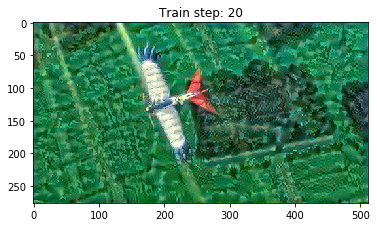

....................

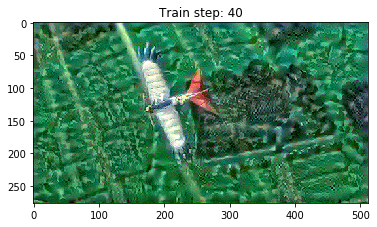

....................

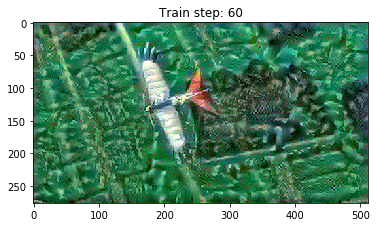

....................

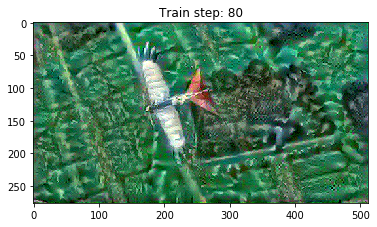

....................

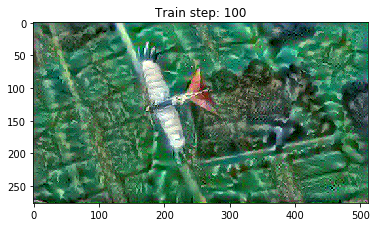

....................

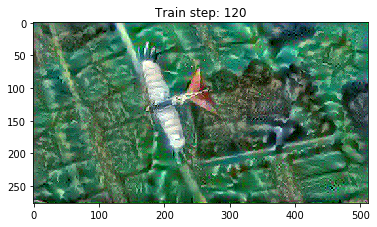

....................

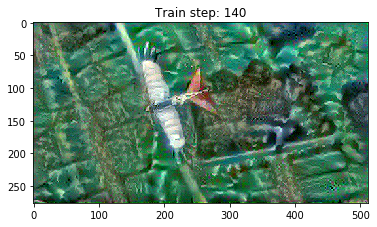

....................

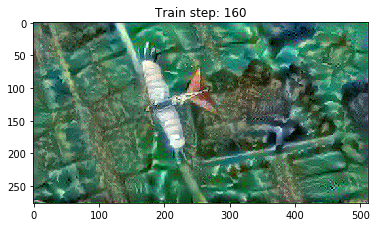

....................

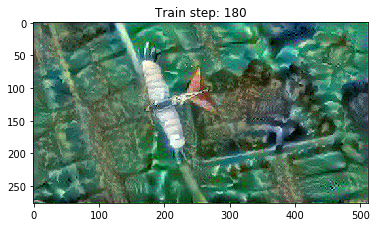

....................

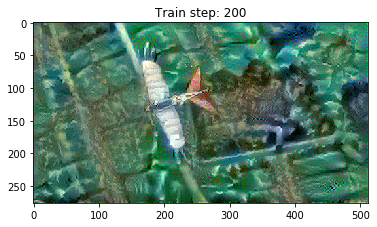

Total time: 542.7


In [25]:
start = time.time()
step = 0

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end="")
    imshow(image.read_value()[0])
    plt.title("Train step: {}".format(step))
    plt.show()
    
end = time.time()
print("Total time: {:.1f}".format(end-start))